# Final Project: Pool Break

Annie Chu and Kyle McCracken

ModSim Studio 1


In [3]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## QUESTION
### What is the optimal speed and position of the cue ball for the best pool break?

Within every pool game is an initial break between the cue ball and the racked pool balls. We seeked to find the best initial position and speed of the cue ball in order to get the most number of balls into pockets within the initial break. 

## METHODS 

### Initializing System

When making our system, we assumed all the balls to be 2D discs and essentially ignored rotational motion. A typical pool table is 2.84 by 1.42 meters; for simplicity's sake, we assumed the table to be 2x1 meters. The mass and radius of the ball is included as well. In addition, we included both coefficients, kinetic and static, of friction between the balls and the cloth of the table.

Our xy plane starts from the middle left of the pool table, meaning (0,-0.5) would be the the bottom left of the pool table and (0, 0.5) would be the top left. 

Also, in the initial racking of the pool balls, we assumed a small space of 0.5cm between all of them to limit multiple-object collisions. Essentially the balls are points with a radius. 

In [34]:
init = State(cx=0.5,cy=0,cvx=3.9,cvy=0, b1x=1.5,
             b1y=.02,b1vx=0,b1vy=0, b2x=1.55,
             b2y=-0.01,b2vx=0,b2vy=0)
state = init
system = System(init = init, fs=0.0166698, fk=0.333396, 
                m=0.1701, r=0.028575, balls=2, dist_step=2, 
                t_0=0, t_end=10, minvel=.01, h=1, w=2, t_cut=1)

,values
init,cx 0.50 cy 0.00 cvx 3.90 cvy ...
fs,0.0166698
fk,0.333396
m,0.1701
r,0.028575
balls,2
dist_step,2
t_0,0
t_end,10
minvel,0.01


#### Calculating Force of Friction
Used to adjust the velocities of the balls while running the simulation. We found the threshold velocity in switching from static to kinetic friction to be 0.5 m/s. 

In [35]:
def f_force(system, v_vector):
    unpack(system)
    if v_vector.mag > 0.5:
        f_force_vector = v_vector.hat() * -fk
        return f_force_vector
    f_force_vector = v_vector.hat() * -fs
    return f_force_vector

#### Rewriting the dot function for distance into a generic function


In [36]:
def dist(v1, v2):
    dist = v1.dist(v2)
    return dist

#### Calculating New Velocities in 2-Object Elastic Collisions 

We used calculations for two-body completely elastic collisions, meaning we assume that although a ball may be touching 2 or more other balls "simultaneously," it is actually not simultaneous and there's a small delay between those collisions. 

Referencing conservation of momentum and kinetic energy, we used an angle-free equation for the new velocities after collisions. 

In [37]:
def newv1(p1, p2, v1, v2):
    v1diff = v1 - v2
    x1diff = p1 - p2
    v1prime = v1 - x1diff * v1diff.dot(x1diff) / (x1diff.mag**2)
    return v1prime

def newv2(p1, p2, v1, v2):
    v2diff = v2 - v1
    x2diff = p2 - p1
    v2prime = v2 - x2diff * v2diff.dot(x2diff) / (x2diff.mag**2)
    return v2prime

### Update function

In [38]:
def update_func(state, t, system):
    unpack(system)
    
    #Initializing Pool Table Dimensions + Coordinate Plane 
    tlc = Vector(0,h/2)
    blc = Vector(0,-h/2)
    trc = Vector(w,h/2)
    brc = Vector(w,-h/2)

    #Initializing Balls, Arrays for Position + Velocity vectors
    ids = linrange(0,balls,1,endpoint=True)
    pos_vectors = []
    vel_vectors = []
    ps = []
    vs = []
    collisions = []
    
    #Adding position and velocity vectors from state to respective arrays, 
    #and checking distance between them
    for b in ids:
        pos_vectors.append(Vector(state[4*b],state[4*b+1]))
        vel_vectors.append(Vector(state[4*b+2],state[4*b+3]))
    checkdist = linrange(0,balls,1)

    #New velocities for ball-bumper collisions
    for b in ids:
        bld = pos_vectors[b].x
        brd = 2 - pos_vectors[b].x
        bbd = 0.5 + pos_vectors[b].y
        btd = 0.5 - pos_vectors[b].y
        if bld <= r or brd <= r:
            vel_vectors[b] = Vector(-vel_vectors[b].x, vel_vectors[b].y)
        if bbd <= r or btd <=r:
            vel_vectors[b] = Vector(vel_vectors[b].x, -vel_vectors[b].y)
    
    #Identifying whether collisions occur
    for b1 in checkdist:
        if b1 == 0:
            collisions.append(0)
        rest = linrange(b1+1,balls,1,endpoint=True)
        for b2 in rest:
            if b1 == 0:
                collisions.append(0)
            if dist(pos_vectors[b1],pos_vectors[b2]) <= 2*r:
                collisions[b1] = collisions[b1] + 1
                collisions[b2] = collisions[b2] + 1

    #New velocities for ball-ball collisions
    for b1 in checkdist:
        rest = linrange(b1+1,balls,1,endpoint=True)
        for b2 in rest:
            if dist(pos_vectors[b1],pos_vectors[b2]) <= 2*r:
                if collisions[b1] > 1 or collisions[b2] > 1:
                    if collisions[b1] > 2 or collisions[b2] > 2:
                        print('well fuck')
                    # do some shit here for when threee balllllls touch eachother
                    print('three ball collision')
                print(str(b1) + ' and ' + str(b2) + ' collided')
                print('1position-1: ' + str(pos_vectors[b1]))
                print('1position-2: ' + str(pos_vectors[b2]))
                dist_error = r - pos_vectors[b1].dist(pos_vectors[b2])
                print('dist error ' + str(dist_error))
                v1prime = newv1(pos_vectors[b1],pos_vectors[b2],vel_vectors[b1],vel_vectors[b2])
                v2prime = newv2(pos_vectors[b1],pos_vectors[b2],vel_vectors[b1],vel_vectors[b2])
                vel_vectors[b1] = v1prime
                vel_vectors[b2] = v2prime
                
    #Updating ball position and velocities at given moment with time step, dt
    for b in ids:
        pb = pos_vectors[b] + vel_vectors[b] * dt
        vb = vel_vectors[b] + (f_force(system, vel_vectors[b])/m) * dt
        if vb.mag <= minvel:
            vb = Vector(0,0)
        vs.append(vb)
        ps.append(pb)

    #Identifying if ball is in pocket 
    for b in ids:
        if pos_vectors[b].dist(tlc) <= 2*r or pos_vectors[b].dist(blc) <= 2*r or pos_vectors[b].dist(trc) <= 2*r or pos_vectors[b].dist(brc) <= 2*r:
            print('ball sunk')
            system.score += 1
            ps[b] = Vector(2+b,2)
            vs[b] = Vector(0,0)

    results = State(cx=ps[0].x,cy=ps[0].y,cvx=vs[0].x,cvy=vs[0].y, b1x=ps[1].x,b1y=ps[1].y,b1vx=vs[1].x,b1vy=vs[1].y, b2x=ps[2].x,b2y=ps[2].y,b2vx=vs[2].x,b2vy=vs[2].y)

    return results

### Run Simulation
Creating TimeFrame in which dt is a function of the initial cue ball velocity in an attempt to balance simulation run time and accuracy

In [39]:
def run_sim(system, update_func):
    system = System(system, dt = system.dist_step / (100* sqrt(state.cvx**2 + state.cvy**2)), score=0)
    unpack(system)

    frame = TimeFrame(columns=init.index)
    frame.loc[t_0] = init
    ts = linrange(t_0, t_end, dt)

    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)

    return frame, score

### Sweeping Position and Velocity Parameters
We sweeped discrete velocities and y-coordinates for the cue ball. We kept the initial x-coordinate location of the cue ball at 1/4 the length of the table from the left.   

In [40]:
def sweep_sim(init,state,system,update_func, sweep_y, sweep_v):
    unpack(system)
    columnlabels = ['y','v','score']
    outcome = DataFrame(index=sweep_y, columns=sweep_v)
    for ystart in sweep_y:
        print('ystart')
        print(ystart)
        init.cy = ystart

        for vstart in sweep_v:
            init.cvx = vstart
            state = init
            system.init = init
            print('vstart')
            print(vstart)
            results, score = run_sim(system, update_func)
            plt.figure(10*vstart+ystart)
            plot(results.cx, results.cy)
            plot(results.b1x, results.b1y)
            plot(results.b2x, results.b2y)
            savefig('graphs/balls----y'+str(ystart)+'----v'+str(vstart) + '--.png')
            outcome.set_value(ystart, vstart, score)

    return outcome


Creating discrete y-coordinate and velocity values to sweep using linspace 

[-0.4  0.   0.4]
[ 1.  10.5 20. ]
ystart
-0.4
vstart
1.0
Saving figure to file graphs/balls----y-0.4----v1.0--.png
vstart
10.5


C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


KeyboardInterrupt: 

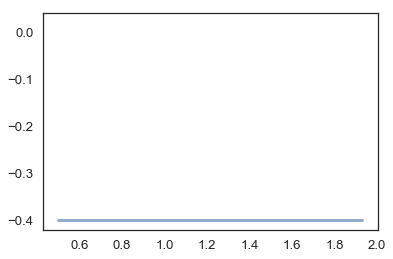

In [33]:
sweep_y = linspace(-.4,.4,3, endpoint=True)
sweep_v = linspace(1,20,3, endpoint=True)

print(sweep_y)
print(sweep_v)

results = sweep_sim(init,state,system,update_func,sweep_y,sweep_v)

print(results)


## RESULTS

s

## INTERPRETATION

Because we sweeped discrete values, we can only assume that the best speed and y-coordinate is AROUND ________________ 

Because we assumed all the balls to be discs, we didn't include rotational motion at all, which means we disregarded torque, cue tip-cue ball interactions, where the cue hits the on the cue ball surface, etc. In addition, because we assumed all the collisions to be completely elastic, we didn't account for energy lost between ball-ball, ball-bumper, and ball-table collisions.

Furthermore, in our model, because we used a discrete dt, there were points in time in which the balls could have intersected one another before recognizing that a collision had occurred. Our biggest annoyance was dealing with long run times due to the fact that we had so many factors and values to sweep over a fairly long time.  

If we were to continue working on this model, we would make the dimensions of the pool table more accurate, have a much smaller time step, make the collisions not completely elastic using restitution coefficients between ball-bumper, ball-ball, and ball-table interactions, and sweep through more speeds and y-coordinates for fine tuning. Other variables we would sweep would include x-coordinates and angle. 

We also calculated a distance error, which was the percentage error between the actual collision distance and the distance they should be at. This was used when trying to fine tune dt values. In this model, the largest distance error was ___________.  
